# Speech Command Recognition


# __Part 1: Computer Audition__

"Computer audition (CA) or machine listening is general field of study of algorithms and systems for audio understanding by [a] machine" (from Wikipedia).
I will tackle a supervised classification task by implementint a Convolutional Neural Network (CNN) using Keras. Specifically, I will be building a speech recognition network. A high-level diagram is displayed below.
<center>
<img src="https://drive.google.com/thumbnail?id=19RSc579LA7jefQmSw1qpdMJkDSywHAm6&sz=w1000" alt="block_cnn"/>
<i>Figure 1: High-level block diagram for part 1.</i>
</center>

## Getting Started with Audio

You might be wondering what the heck these orange/purplish heat maps are and what they have to do with audio. The answer is spectrograms and proven representation. When audio is recorded, physical sound waves (e.g. air being compressed and decompressed in a fraction of a second) are first converted into analog information, which in turn gets converted into digital sound waves, a.k.a. raw audio data which looks like this -  
<center>
<img src="https://drive.google.com/thumbnail?id=1erxL8OMi2pzYblMafPc2lgG_0JP5NeMi&sz=w300" alt="wave"/>
<br>
<i>Figure 2: An audio wave.</i>
</center>

This is just a long sequence of amplitude values, e.g. $[-0.67, -0.15, 0, 0.53, 0.86, ...]$. The number of amplitude values captured per second is called the ___sample rate___. The number of bits used to describe each sample (each value) is called the ___bit depth___. The higher the sample rate, the more frequencies we can capture; the higher the bit depth, the more volume levels we can capture.  
  
However, there are other ways to represent sound.
While raw audio is a time-domain representation, __spectrograms__ are a time-frequency representation, with the x-axis representing time and the y-axis representing frequency. The color represents the magnitude. Usually, the brighter the color, the louder the frequency. Note: they are presented with color, but this is simply to make for a more intelligible image, spectrograms are usually analyzed as a 2D array, which is essentially a grayscale image. 



<center>
<img src="https://drive.google.com/thumbnail?id=122TlTGZ04PcNCwggGcwfcMSt8Z7x_jLP&sz=w600" alt="wave"/>
<br>
<i>Figure 3: Spectrograms of the words "hot", "hat", "hit" & "head" spoken once with a high-pitched voice (top), and then again with a lower pitched voice (bottom). Taken from <a href="https://auditoryneuroscience.com/vocalizations-speech/formants-harmonics">auditoryneuroscience.com</a>.</i>
</center>

Spectrograms are often used for computer audition tasks as they generally offer a more effective representation. They make it easier for the model by essentially performing feature extraction, pulling out high level information. This information can then be used by CNNs, which perform well on image data.

Spectrograms are commonly generated by applying a transformation called "Discrete Fourier Transform" (DFT) to fixed-sized portions of the audio data. From Wikipedia: "Digitally sampled data, in the time domain, is broken up into chunks, which usually overlap, and Fourier transformed to calculate the magnitude of the frequency spectrum for each chunk. Each chunk then corresponds to a vertical line in the image; a measurement of magnitude versus frequency for a specific moment in time (the midpoint of the chunk). These spectrums or time plots are then 'laid side by side' to form the image." 

A __Short-time Fourier Transform__ (STFT) does just that, it applies a DFT to a fixed-size segment/window of the audio data, and slides that window along the data, such that we can see how the frequncy information changes over time. The entries of the 2D array generated by the STFT are actually complex numbers. The magnitude (or absolute value) of the STFT is called ___spectrogram___. You can play with [_this cool interactive visualization_](https://musiclab.chromeexperiments.com/Spectrogram/) to better understand spectrograms of different sounds.

## Import Needed Packages

We'll be using Colab's GPU for this one, so navigate to `Runtime>Change runtime type` and make sure you have GPU selected. Then, run the cell below to import the packages we'll be using.

In [ ]:
###########################
# DO NOT MODIFY THIS CELL #
###########################

!pip -q install librosa  # installing librosa
!pip3 -q install pydub

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa, librosa.display  # python package for audio/music analysis
import matplotlib.pyplot as plt
import sklearn
import sys, os
from IPython.display import Audio
from IPython import display

## Obtaining the Dataset

We will use one of TensorFlow's publicly available datasets for audio processing: "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition." It contains one-second (or less) audio clips with the following contents: silence, an unknown word, "yes", "no", "up", "down", "left", "right", "on", "off", "stop", or "go". Thanks to the `tensorflow_datasets` package, we can download it with a single line of code. This dataset is over 8 GB so it'll take a while (took me around 15 minutes).

In [ ]:
ds, ds_info = tfds.load('speech_commands', split=['train', 'validation', 'test'],
                        as_supervised=True, with_info=True)  # download the data
train_set, valid_set, test_set = ds  # get train-validation-test split
ds_info  # display dataset info

tfds.core.DatasetInfo(
    name='speech_commands',
    version=0.0.2,
    description='An audio dataset of spoken words designed to help train and evaluate keyword
spotting systems. Its primary goal is to provide a way to build and test small
models that detect when a single word is spoken, from a set of ten target words,
with as few false positives as possible from background noise or unrelated
speech. Note that in the train and validation set, the label "unknown" is much
more prevalent than the labels of the target words or background noise.
One difference from the release version is the handling of silent segments.
While in the test set the silence segments are regular 1 second files, in the
training they are provided as long segments under "background_noise" folder.
Here we split these background noise into 1 second clips, and also keep one of
the files for the validation set.',
    homepage='https://arxiv.org/abs/1804.03209',
    features=FeaturesDict({
        'audio': Audio(shap

Let's listen to a few files from the dataset. Bear in mind that the sample rate of the audio recordings is 16 kHz.

In [ ]:
sr = 16000  # sample rate
example = train_set.take(3)  # example is (audio, label)

for signal, label in tfds.as_numpy(example):
  print('signal = ', signal, '; label =', label)
  display.display(Audio(signal, rate=sr))

signal =  [-15 -18 -12 ...  16  21  25] ; label = 4


signal =  [  75   29  -85 ... -343  304  879] ; label = 5


signal =  [0 0 2 ... 2 1 1] ; label = 7


Now that we have our data, let's visualize and listen to one of the recordings.

## 1. Visualization

### 1.1 As a waveform

Text(0.5, 0, 'Amplitude')

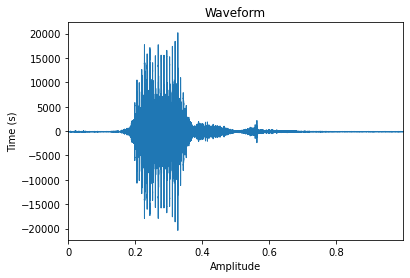

In [ ]:
signals = []
labels = []

for signal, label in tfds.as_numpy(example):
    signals.append(signal)
    labels.append(label)

y=[]
for item in signals[0]:
    y.append(float(item))

y = np.array(y)

fig, ax = plt.subplots()
librosa.display.waveplot(y, sr, x_axis='time', ax=ax)
ax.set_title("Waveform")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Amplitude")

### 1.2 As a Spectogram
Next, Let's plot the spectrogram of the same signal by applying the STFT using the librosa package and taking the absolute value of the result.

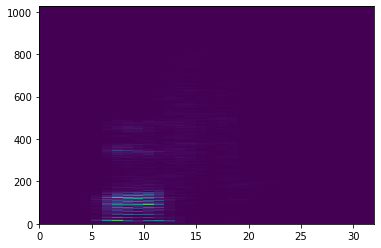

In [ ]:
S = np.abs(librosa.stft(y))

plt.pcolormesh(S)
plt.show()

### Better Spectogram
A little hard to notice the data right? let's scale the data and make the visualization more intelligible.

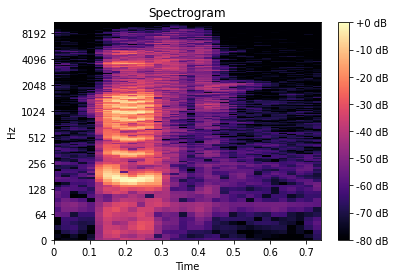

In [ ]:
# TODO: your code here
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title("Spectrogram")
plt.colorbar(format="%+2.0f dB")

## 2. Preprocessing 

Before we build our network, we need to perform some preprocessing to create a spectrogram dataset. An alternative you might see in practice is to make the input transformation a part of the network (either as a trainable or non-trainable layer), which would allow you to modify the transformation without having to process the dataset every time.

### 2.1 Filtering 

Our model will be receiving fixed-sized inputs, so to keep things simple, we will simply filter out any recording which is not exactly 16,000 samples (equivalent to 1-second with a 16-kHz sample rate). Use TensorFlow's Dataset API. Do this to all sets (train, valid, and test).

In [ ]:
# filter the data to ensure consistent shape (removes ~8,000 samples)
train_set = train_set.filter(lambda x, y: len(x)==16000)
valid_set = valid_set.filter(lambda x, y: len(x)==16000)
test_set = test_set.filter(lambda x, y: len(x)==16000)

### 2.2 Transformation

Our model will be receiving spectrograms. Use TensorFlow's Dataset API, signal module, and other TensorFlow functions to transform the data into magnitue spectrograms. In particular, use a decibel-scaled spectrogram with 512 for your number of fast-fourier transforms (frame length) and a hop length (frame step) of 160. `get_db_spec()` receives a signal as input and returns the decibel-scaled spectrogram as output. Then, outside the function, transform the data using the function.  Which is then applied to all sets (train, valid, and test). 

In [ ]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way. Based on:
    https://librosa.org/doc/latest/generated/librosa.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))
    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

def get_db_spec(sig):
  sig = tf.cast(sig, tf.float32)
  spec = tf.signal.stft(sig, frame_length=512, frame_step=160)
  spec = tf.math.square(tf.math.abs(spec))

  return power_to_db(spec)
  

# TODO: your code here
train_set = train_set.map(lambda x, y: (tf.transpose(get_db_spec(x)), y))
valid_set = valid_set.map(lambda x, y: (tf.transpose(get_db_spec(x)), y))
test_set = test_set.map(lambda x, y: (tf.transpose(get_db_spec(x)), y))

### 2.3 Normalization

There are different ways to normalize data. For simplicity, let's perform per-sample standardization. The `normalize()` function recieves a `tf.Tensor` tensor and returns a standardized value by subtracting the mean of the tensor and divinding by the standard deviation plus some tiny value to avoid dividing by zero (use `TensorFlow` functions here). Then, it is also applied to the 3 subsets of the dataset (train, valid, and test).


In [ ]:
def normalize(x, epsilon=1e-10):
  # TODO: your code here
  x = tf.divide(
      tf.subtract(x, tf.reduce_mean(x)),
      tf.add(tf.math.reduce_std(x), epsilon)
  )

  return x

# TODO: your code here
train_set = train_set.map(lambda x, y: (normalize(x), y))
valid_set = valid_set.map(lambda x, y: (normalize(x), y))
test_set = test_set.map(lambda x, y: (normalize(x), y))

## Problem 3: Architecture

Now we're ready to build our CNN model. You'll be implementing the model shown below. Use `tensorflow.keras` (either the sequential API or functional API) to implement and return the model inside the `my_cnn` function. 

Notice that the leftmost block is the reshaped input of shape 257x97x1 (CNN implementations usually require a 3rd dimension because of potential color channels). The convolutional layers are followed by batch normalization layers, which are followed by ReLU activations. Padding is always used such that all pixels are considered during the convolution _and_ pooling processes. Lastly, the output layer is a dense layer with a softmax activation. 

Don't forget to compile the model before returning it. Use the `adam` optimizer and for the loss function use sparse categorical crossentropy, the sparse part is to tell the model that our targets are __not__ one-hot encoded. Be sure to run the cell to see the model summary.

<center>
<img src="https://drive.google.com/thumbnail?id=1bAtVD-ffxyVi91kzfghXk3P0_rTDlCxf&sz=w3800" alt="cnn_diagram"/>
<i>Figure 4: Diagram of a deep convolutional neural network for you to implement.</i>
</center>

In [ ]:
# set random seeds for reproducibility
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
from tensorflow.keras import layers, models


input_shape = (257, 97)
        
def my_cnn(n_classes=12):
  # TODO: your code here

  # comemented before each convolution layers is the supposed architecture convolution layers.
  # i could not use the defined architecture to get the required accuracies. Therefore I am 
  # altering it a bit to get the desired testing and validating accuracies.
  # all my modifications were to change the filter sizes and change the last layer to Flatten

  model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([257,97,1], input_shape=input_shape),

    # tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', activation='relu')
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),

    # tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),

    # tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same'),

    # tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    
    # tf.keras.layers.Dense()
    tf.keras.layers.Flatten(), 

    tf.keras.layers.Dense(units=n_classes, activation='softmax')
  ])

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

model = my_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 257, 97, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 97, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 257, 97, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 257, 97, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 49, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 49, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 129, 49, 64)       2

## Problem 4: Train & Test

Let's train and test our model.

### 4.1 Training

Using Colab's GPU, with batch size 128, each epoch took me ~5 minutes. I was able to reach 90% validation accuracy after a few epochs and 95% after a few more.

In [ ]:
# set random seeds for reproducibility
np.random.seed(42)
from tensorflow.random import set_seed
set_seed(42)
from keras.callbacks import ModelCheckpoint

# TODO: your code here (model training)

batch_size = 128
train_set = train_set.batch(batch_size)
valid_set = valid_set.batch(batch_size)
history = model.fit(train_set, batch_size=batch_size, epochs=8, verbose=1, validation_data = valid_set)
    

Epoch 1/8
      2/Unknown - 0s 96ms/step - loss: 13.1754 - accuracy: 0.2930 WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0677s vs `on_train_batch_end` time: 0.1237s). Check your callbacks.


602/602 [==============================] - 437s 726ms/step - loss: 1.0541 - accuracy: 0.7463 - val_loss: 0.5781 - val_accuracy: 0.8019
Epoch 2/8
602/602 [==============================] - 438s 728ms/step - loss: 0.3131 - accuracy: 0.9064 - val_loss: 0.2740 - val_accuracy: 0.9206
Epoch 3/8
602/602 [==============================] - 439s 730ms/step - loss: 0.2179 - accuracy: 0.9347 - val_loss: 0.2239 - val_accuracy: 0.9307
Epoch 4/8
602/602 [==============================] - 441s 732ms/step - loss: 0.1683 - accuracy: 0.9493 - val_loss: 0.2504 - val_accuracy: 0.9284
Epoch 5/8
602/602 [==============================] - 437s 726ms/step - loss: 0.1411 - accuracy: 0.9559 - val_loss: 0.1761 - val_accuracy: 0.9499
Epoch 6/8
602/602 [==============================] - 441s 733ms/step - loss: 0.1193 - accuracy: 0.9626 - val_loss: 0.3826 - val_accuracy: 0.9025
Epoch 7/8
602/602 [==============================] - 438s 727ms/step - loss: 0.1029 - accuracy: 0.9674 - val_loss: 0.1708 - val_accuracy: 0.

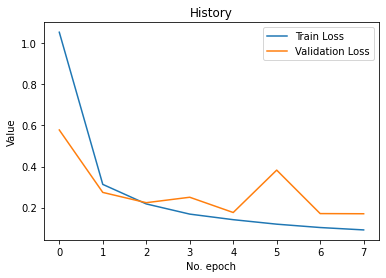

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('History')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

### 4.2 Test (15 Points)
Let's see how our model performs on the test set.  
<center>
<img src="https://drive.google.com/thumbnail?id=12aSyDa53eBT-os4EJYFYGtwYXo6vy-ib&sz=w700" alt="wave"/>
<br>
</center>

In [ ]:
class_names = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up',
               'yes','unknown', 'silence']

test_set = test_set.batch(batch_size)
model.evaluate(test_set)


In [ ]:
x_train = np.concatenate([x for x,y in test_set], axis=0)

In [ ]:
y_train =np.concatenate([y for x, y in test_set], axis=0)

In [ ]:
y_pred = np.argmax(model.predict(x_train), axis=1)

Text(114.0, 0.5, 'True label')

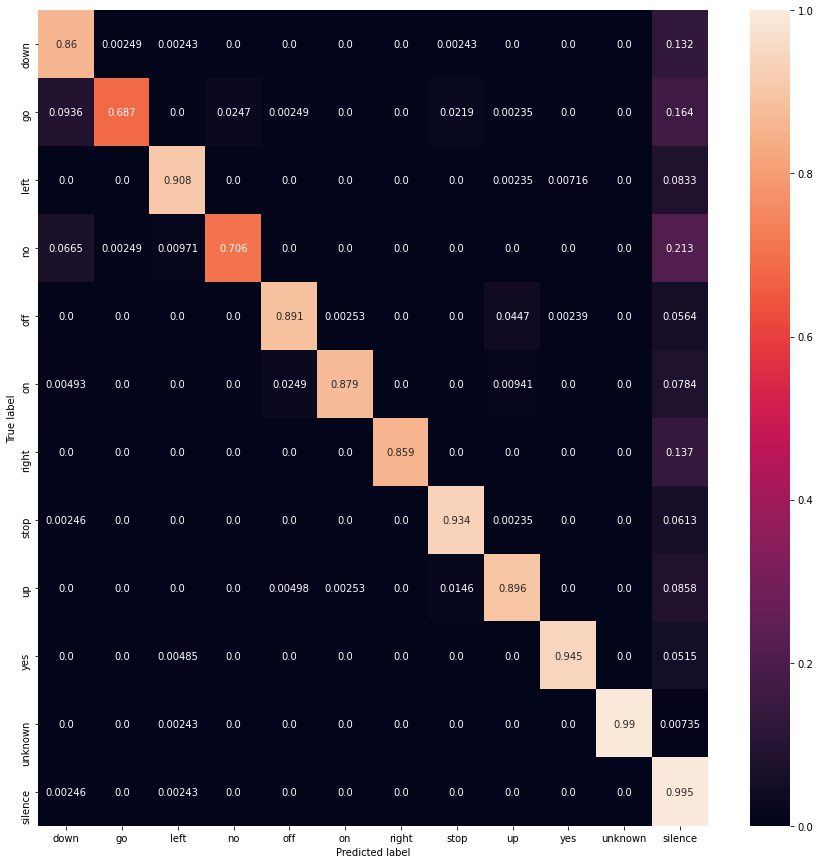

In [ ]:
# TODO: your code here (confusion matrix)
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sns

cf_matrix = confusion_matrix(y_train, y_pred)
cf_matrix = cf_matrix / np.sum(cf_matrix, axis=1)

fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cf_matrix, annot=True, fmt='.3', xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

### 4.3 Fun Test (Ungraded)

Let's use the Web Audio API to see if our model can predict correctly when listening to our own voice. Run the cell below to record a 1-second recording of yourself saying one of the target words (e.g. "up", "down", etc.). Listen to the result to ensure that the recording is good (try speaking right after "Recording..." appears). Then, run the next cell to see if your model predicted correctly.

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1.1):
  print('Recording...')
  display.display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  fp = 'my_rec.wav'
  with open(fp,'wb') as f:
    f.write(b)
  print('Done.')
  return fp

fp = record()
signal, sr = librosa.load(fp, sr=16000)
signal = signal[-sr:]
display.display(Audio(signal, rate=sr))

If your recording sounds reasonable, run the next cell to see if the model recognizes your speech!

In [ ]:
# predict a single recording
spec = normalize(get_db_spec(signal))
one_hot_pred = model.predict(np.array([spec]))
pred_to_text = class_names[np.argmax(one_hot_pred)]
print('You said', pred_to_text)

You said yes


# **Part 2: Computer Vision (Image Classification on CIFAR-10)**

In this section, we will explore implementing and improving upon some simple convolutional networks to perform image recognition on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset consists of $32 \times 32$ RGB images of objects from 10 classes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, and `truck`.

We'll be using Colab's GPU to expedite our training, so before we get started, navigate to `Runtime>Change runtime type` and make sure you have GPU selected.

<center>
<img src="https://drive.google.com/thumbnail?id=1wgoaxYIpKCq9Ihu7rfrursmsFgz318HN&sz=w600" alt="block_cnn"/>
<br>
<i>The CIFAR-10 Dataset: 10 random images from each class.</i>
</center>

### **Imports and Data Preparation**

Now, let's load and format the dataset, which is conveniently available directly from Keras, whilst importing any packages we might need.

In [ ]:
# DO NOT MODIFY THIS CELL
import numpy as np
import tensorflow as tf
from tensorflow import keras
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt

classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
                    'frog', 'horse', 'ship', 'truck'])
(train, test) = keras.datasets.cifar10.load_data()

# convert uint8 RGB images to float RGB images in range [0,1]
train_input = train[0].astype(np.float32) / 255.0
test_input = test[0].astype(np.float32) / 255.0
# convert class labels to one-hot encoding
train_targets = keras.utils.to_categorical(train[1], num_classes=10)
test_targets = keras.utils.to_categorical(test[1], num_classes=10)

170500096/170498071 [==============================] - 2s 0us/step


### ** Building a Simple Model**

Let's start with a fairly barebones CNN architecture to tackle this learning problem, and dub it "model 1". The architecture details are displayed below.

$$
\begin{array}{c|c|c}
\text{Layer Type} & \text{Activation} & \text{Output Shape} \\
\hline
\text{Input} & \text{N/A} & (32,32,3) \\
\text{Conv2D} & \text{ReLU} & (32,32,8) \\
\text{MaxPool2D} & \text{N/A} & (16,16,8) \\
\text{Conv2D} & \text{ReLU} & (16,16,16) \\
\text{MaxPool2D} & \text{N/A} & (8,8,16) \\
\text{Flatten} & \text{N/A} & (1024,) \\
\text{Dense} & \text{Softmax*} & (10,)
\end{array}
$$

$\text{*}$ omit this activation; we'll use a more numerically stable training method that already has this in the loss function.

All convolutional filters have $3 \times 3$ spatial size, and all max pooling is done over a $2 \times 2$ grid in the spatial dimensions. We always use `same` padding to preserve the spatial dimensions. All trainable layers learn both weights and biases. The batch dimension has been omitted from the "$\text{Output Shape}$" column.

#### **1.1 Implementation **

Implement the above architecture using the Keras API in the function **`model_1`** provided below, which should simply create a Keras model and return it. For weight initialization, pick an appropriate initializer for the layer's activation function. Don't worry about compiling the model; we'll do that later.

In [ ]:
def model_1():
  model1 = tf.keras.Sequential([
       keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)),
       keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
       keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
       keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
       keras.layers.Flatten(),
       keras.layers.Dense(10)
    ])
  
  return model1


As a sanity check, let's visualize the implemented model, to confirm that it matches the description above (and that the model can be created without error). Note: the question mark you'll see in each shape, e.g. (?, 32, ...), is simply a placeholder for the amount of training data.

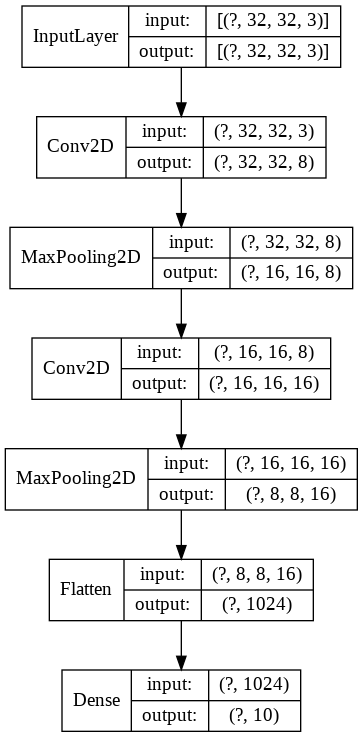

In [ ]:
keras.utils.plot_model(model_1(), show_shapes=True, show_layer_names=False)

### Building a More Complex Model

Next, let's also create a similar, but more complex model that we'll call "model 2". Its architecture is displayed below.

$$
\begin{array}{c|c|c}
\text{Layer Type} & \text{Activation} & \text{Output Shape} \\
\hline
\text{Input} & \text{N/A} & (32,32,3) \\
\text{Conv2D} & \text{ReLU} & (32,32,64) \\
\text{Conv2D} & \text{ReLU} & (32,32,64) \\
\text{MaxPool2D} & \text{N/A} & (16,16,64) \\
\text{Conv2D} & \text{ReLU} & (16,16,128) \\
\text{Conv2D} & \text{ReLU} & (16,16,128) \\
\text{MaxPool2D} & \text{N/A} & (8,8,128) \\
\text{Conv2D} & \text{ReLU} & (8,8,192) \\
\text{Conv2D} & \text{ReLU} & (8,8,192) \\
\text{MaxPool2D} & \text{N/A} & (4,4,192) \\
\text{Conv2D} & \text{ReLU} & (4,4,256) \\
\text{Conv2D} & \text{ReLU} & (4,4,256) \\
\text{MaxPool2D} & \text{N/A} & (2,2,256) \\
\text{Flatten} & \text{N/A} & (1024,) \\
\text{Dense} & \text{ReLU} & (512,) \\
\text{Dense} & \text{Softmax*} & (10,)
\end{array}
$$

$\text{*}$ as with model 1, omit this activation.

The filter and padding details for the layers are the same as in model 1.

#### **2.1 Implementation**

Just like you did with model 1, implement model 2 in the function **`model_2`** provided below.

In [ ]:
def model_2():

    model2 = tf.keras.Sequential([
                                    
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=192, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=192, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(10)
        ])
  
    return model2


Again, let's visualize this one, too.

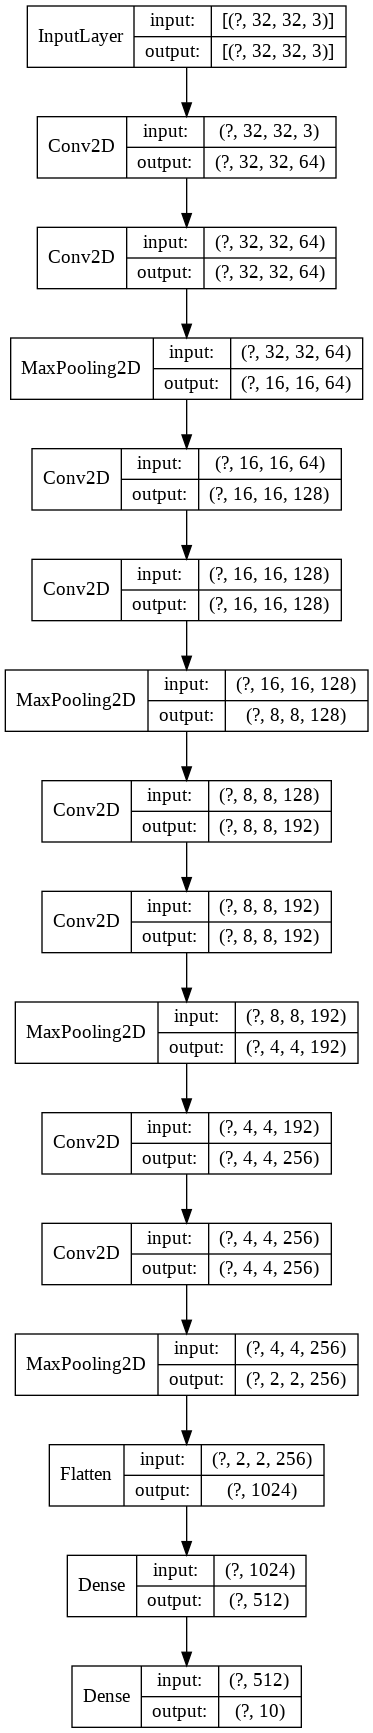

In [ ]:

keras.utils.plot_model(model_2(), show_shapes=True, show_layer_names=False)

### **Problem 3: Training experiments**

To get a sense of how these models perform on our dataset without taking much training time, let's see how the loss and accuracy of each model evolves during the first ten training epochs. Although each image in the dataset is small, there are 50,000 training examples, so this may take a minute or two.

Epoch 1/10
500/500 - 3s - loss: 1.6972 - categorical_accuracy: 0.3999 - val_loss: 1.4559 - val_categorical_accuracy: 0.4792
Epoch 2/10
500/500 - 2s - loss: 1.4079 - categorical_accuracy: 0.5008 - val_loss: 1.3428 - val_categorical_accuracy: 0.5201
Epoch 3/10
500/500 - 2s - loss: 1.3188 - categorical_accuracy: 0.5358 - val_loss: 1.2865 - val_categorical_accuracy: 0.5412
Epoch 4/10
500/500 - 2s - loss: 1.2575 - categorical_accuracy: 0.5623 - val_loss: 1.2394 - val_categorical_accuracy: 0.5612
Epoch 5/10
500/500 - 2s - loss: 1.2096 - categorical_accuracy: 0.5795 - val_loss: 1.2070 - val_categorical_accuracy: 0.5723
Epoch 6/10
500/500 - 2s - loss: 1.1707 - categorical_accuracy: 0.5917 - val_loss: 1.1723 - val_categorical_accuracy: 0.5874
Epoch 7/10
500/500 - 2s - loss: 1.1393 - categorical_accuracy: 0.6049 - val_loss: 1.1448 - val_categorical_accuracy: 0.5977
Epoch 8/10
500/500 - 2s - loss: 1.1076 - categorical_accuracy: 0.6171 - val_loss: 1.1146 - val_categorical_accuracy: 0.6135
Epoch 9/

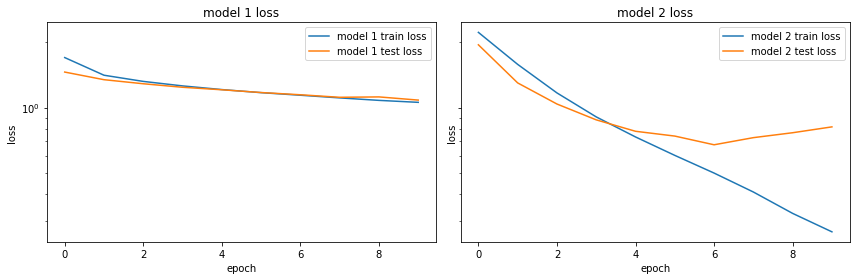

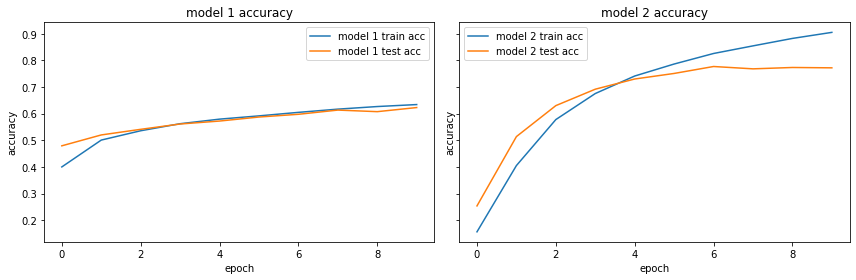

In [ ]:
# DO NOT MODIFY THIS CELL
# get the models
m1 = model_1()
m2 = model_2()
hist = []
for (m_i, model) in enumerate([m1, m2]):
  opt = keras.optimizers.Nadam() # optimizer
  loss = keras.losses.CategoricalCrossentropy(from_logits=True) # loss function
  # compile and train, saving the training history (contains losses and metrics)
  model.compile(optimizer=opt, loss=loss, metrics=['categorical_accuracy'])
  hist.append(model.fit(x=train_input, y=train_targets,
                        validation_data=(test_input, test_targets),
                        batch_size=100, epochs=10, verbose=2))
# generate loss plots
fsize = plt.rcParams.get('figure.figsize') # the default figure size for scaling purposes
# create the plots side-by-side w/ locked y-axis for better comparison
num_plots = len(hist)
_, axarr = plt.subplots(1, num_plots, figsize=(fsize[0]*num_plots, fsize[1]), sharey=True)
for (m_i, hist_i) in enumerate(hist):
  axarr[m_i].semilogy(hist_i.history['loss'], label='model {:d} train loss'.format(m_i + 1))
  axarr[m_i].semilogy(hist_i.history['val_loss'], label='model {:d} test loss'.format(m_i + 1))
  axarr[m_i].set_xlabel('epoch')
  axarr[m_i].set_ylabel('loss')
  axarr[m_i].set_title('model {:d} loss'.format(m_i + 1))
  axarr[m_i].legend()
plt.tight_layout()
# generate accuracy plots (pretty much same procedure as with loss plots)
_, axarr = plt.subplots(1, num_plots, figsize=(fsize[0]*num_plots, fsize[1]), sharey=True)
for (m_i, hist_i) in enumerate(hist):
  axarr[m_i].plot(hist_i.history['categorical_accuracy'], label='model {:d} train acc'.format(m_i + 1))
  axarr[m_i].plot(hist_i.history['val_categorical_accuracy'], label='model {:d} test acc'.format(m_i + 1))
  axarr[m_i].set_xlabel('epoch')
  axarr[m_i].set_ylabel('accuracy')
  axarr[m_i].set_title('model {:d} accuracy'.format(m_i + 1))
  axarr[m_i].legend()
plt.tight_layout()

To get some numbers, let's also print out the best test accuracies for the models.

In [ ]:
print("best test acc:")
for (m_i, hist_i) in enumerate(hist):
  print("model {:d}: {:f}%".format(m_i + 1, max(hist_i.history['val_categorical_accuracy']) * 100.0))

best test acc:
model 1: 62.300003%
model 2: 77.730000%


#### **3.1 Analysis (10 Points)**

If you implemented the models correctly, your plots will look similar to the plots we got:

<center>
<img src="https://drive.google.com/thumbnail?id=10cAw3ftiegoWkPExynOrK_21uhZl68eF&sz=w800" alt="wave"/>
<br>
</center>

Also, here's the output we got when printing the best test accuracies for the models:
```
best test acc:
model 1: 62.760001%
model 2: 78.359997%
```

How well does each model fit to the training and test sets? How well do they perform relative to each other?  Why do you think our models behave this way?

From the results above, I believe that I have implemented the model correctly since I got a similar result.
  
Model 1 performs relatively consistent between training and testing. However, the accuracy of the categorization is quite low. Model 2 on the other hand did exceptionally well on the train set, yet performs just slightly better than model 1 at categorizing the data.  
  
From what we gathered above, we can conclude that model 1 underfits the data. Thus, it's training and testing accuracies are both quite low. Conversely, model 2 overfits the data. Thus, it performs exceptionally well on the training data, yet only slightly better than model 1 at testing accuracy.


### **Problem 4: Improving the model**

Based off of your observations in the above experiment, try to improve upon model 2 using some techniques discussed in the text and class.


#### **4.1 Implementation**

Write your code below implementing the modified model, training it, and displaying training plots similar to the ones above. A template based on the code above has been provided to help you get started, including code to train and plot the results, but feel free to modify or deviate from it as necessary.

As a guideline, try to get your improved model's accuracy on the test set either above $82\%$, or at least $5\%$ greater than the best accuracy the baseline model 2 gets above. Due to the stochastic nature of training, your results will vary with every run; it suffices that the result you submit meets at least one of these criteria.

Epoch 1/10
500/500 - 10s - loss: 1.5161 - categorical_accuracy: 0.4953 - val_loss: 1.5091 - val_categorical_accuracy: 0.5516
Epoch 2/10
500/500 - 10s - loss: 0.8171 - categorical_accuracy: 0.7152 - val_loss: 0.8146 - val_categorical_accuracy: 0.7243
Epoch 3/10
500/500 - 10s - loss: 0.6163 - categorical_accuracy: 0.7864 - val_loss: 0.9800 - val_categorical_accuracy: 0.6781
Epoch 4/10
500/500 - 10s - loss: 0.4942 - categorical_accuracy: 0.8291 - val_loss: 0.8751 - val_categorical_accuracy: 0.7235
Epoch 5/10
500/500 - 10s - loss: 0.3909 - categorical_accuracy: 0.8650 - val_loss: 0.6180 - val_categorical_accuracy: 0.8032
Epoch 6/10
500/500 - 10s - loss: 0.3132 - categorical_accuracy: 0.8919 - val_loss: 0.5961 - val_categorical_accuracy: 0.8163
Epoch 7/10
500/500 - 10s - loss: 0.2522 - categorical_accuracy: 0.9119 - val_loss: 0.6021 - val_categorical_accuracy: 0.8167
Epoch 8/10
500/500 - 10s - loss: 0.2008 - categorical_accuracy: 0.9289 - val_loss: 0.7093 - val_categorical_accuracy: 0.8021


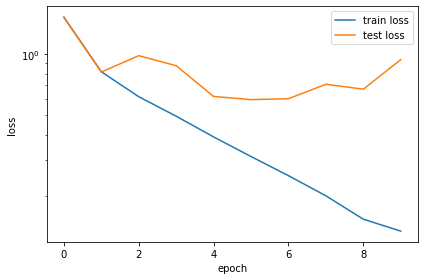

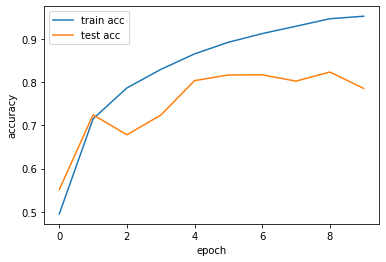

In [ ]:
def model_2_improved():
    model2 = tf.keras.Sequential([
                                    
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='selu', padding='same', input_shape=(32,32,3)),
        keras.layers.Conv2D(filters=64, kernel_size=3, activation='selu', padding='same'),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('selu'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=128, kernel_size=3, activation='selu', padding='same'),
        keras.layers.Conv2D(filters=128, kernel_size=3, activation='selu', padding='same'),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('selu'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=192, kernel_size=3, activation='selu', padding='same'),
        keras.layers.Conv2D(filters=192, kernel_size=3, activation='selu', padding='same'),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('selu'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        keras.layers.Conv2D(filters=256, kernel_size=3, activation='selu', padding='same'),
        keras.layers.Conv2D(filters=256, kernel_size=3, activation='selu', padding='same'),
        keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('selu'),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),

        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        keras.layers.Dense(512, activation='selu', kernel_initializer='lecun_normal'),
        keras.layers.Dense(10)
        ])
  
    return model2

# Provided Code
model = model_2_improved() # get model
opt = keras.optimizers.Nadam() # optimizer
loss = keras.losses.CategoricalCrossentropy(from_logits=True) # loss function
# compile and train, saving history for use in plotting our losses and metrics
model.compile(optimizer=opt, loss=loss, metrics=['categorical_accuracy'])
improved_hist = model.fit(x=train_input, y=train_targets,
                 validation_data=(test_input, test_targets),
                 batch_size=100, epochs=10, verbose=2)
# plot losses
plt.figure()
plt.semilogy(improved_hist.history['loss'], label='train loss')
plt.semilogy(improved_hist.history['val_loss'], label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
# plot accuracies
plt.figure()
plt.plot(improved_hist.history['categorical_accuracy'], label='train acc')
plt.plot(improved_hist.history['val_categorical_accuracy'], label='test acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
# print best
print("best test acc: {:f}%".format(max(improved_hist.history['val_categorical_accuracy']) * 100.0))

#### **4.2 Dicussion and Analysis**

Provide some writing below describing what modifications you made to model 2's architecture and/or training procedure, as well as your rationale behind these modifications. How well does your improved model perform?  

For the improved model, I added batch normalization after the convolution layers. This helps the model to converge faster and more stable. Since the model 2 sometimes experience vanishing gradients (the model accuracy flatlined at 0.1 and does not improve), utilizing batch normalization significantly alleviates this. 
  
I also changed the activation function from "ReLU" to "SeLU" for self normalization since the activation function can somewhat improve the training result. I played around with the activation functions and SeLU provided the best result. I also added Dropouts as a method of regularizations. Regularizing is a method to prevent overfitting as we observed in the graphs above.   
  
Despite the measures taken above, the model still did not fit the data as well as I would want to. However, it is a step up from model 2. From the testing above, we can see that the model performs consistently better on the test_set, averaging 3-5% better test accuracy.